# GO-SHIP Data Processing

- Uses original bottle data from CCHDO and transforms into usable dataframe for RF training. 
- Outputs .csv for ship and float data with necessary fields for resampling


https://cchdo.ucsd.edu/data/15500/325020190403_do.pdf



https://cchdo.ucsd.edu/cruise/325020190403




In [1]:
# Import packages

# pip install plotly
# pip install PyCO2SYS
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean
import gsw

from matplotlib.colors import LogNorm
# import PyCO2SYS as pyco2

import sgmod_main as sg

# Plotting Packages
import matplotlib.pyplot as plt
from cmocean import cm as cmo
import seaborn as sns
import matplotlib.patches as patch
from labellines import labelLine, labelLines

import sgmod_DFproc as dfproc

# GO-SHIP Bottle Data

In [2]:
file_path = '../data/go-ship/'
filename = '325020190403_bottle.nc'
ship = xr.open_dataset(file_path + filename)

ship_ctd = xr.open_dataset(file_path + '325020190403_ctd.nc')

## Assess original variables and cut off data.

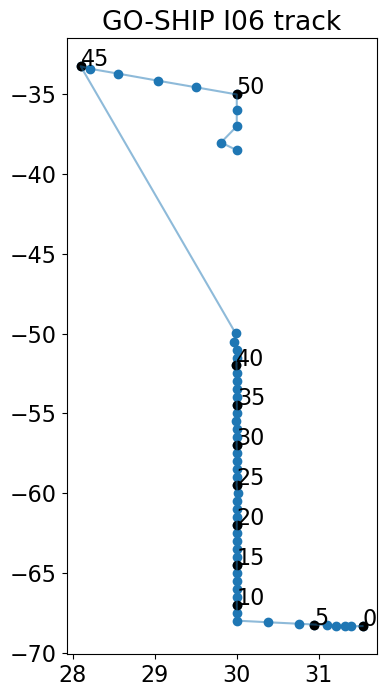

In [3]:
# Ship Track 

fig = plt.figure(figsize=(4,8))
plt.title('GO-SHIP I06 track')
plt.scatter(ship.longitude, ship.latitude)
plt.plot(ship.longitude, ship.latitude, alpha=0.5)

for nprof in ship.N_PROF.values[::5]:
    plt.scatter(ship.longitude[ship.N_PROF == nprof], ship.latitude[ship.N_PROF == nprof], c='k')  
    plt.text(ship.longitude[ship.N_PROF == nprof], ship.latitude[ship.N_PROF == nprof], nprof, c='k') 


In [5]:
ship.sel(N_PROF=44).ctd_temperature # profiles 45 and above have high temp

<xarray.DataArray 'ctd_temperature' (N_LEVELS: 36)>
[36 values with dtype=float64]
Coordinates:
    expocode   object ...
    station    object ...
    cast       int32 ...
    sample     (N_LEVELS) object ...
    time       datetime64[ns] ...
    latitude   float64 ...
    longitude  float64 ...
    pressure   (N_LEVELS) float64 ...
Dimensions without coordinates: N_LEVELS
Attributes:
    whp_name:         CTDTMP
    whp_unit:         ITS-90
    standard_name:    sea_water_temperature
    units:            degC
    reference_scale:  ITS-90
    C_format:         %.4f
    C_format_source:  input_file

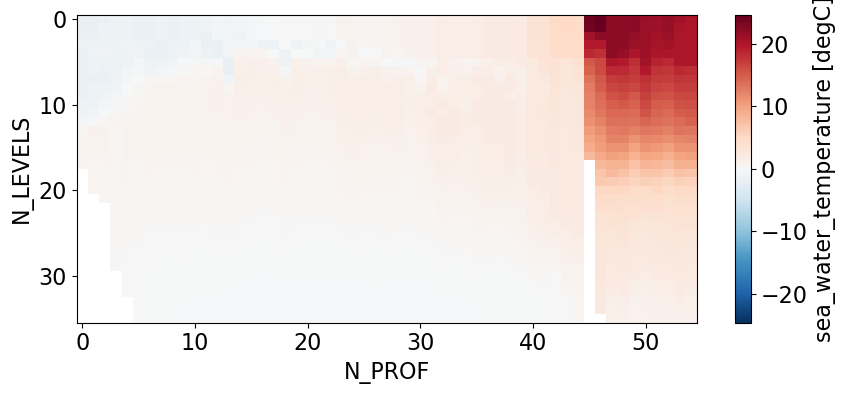

In [4]:
fig = plt.figure(figsize=(10,4))
ship.ctd_temperature.T.plot()
ax = fig.gca()
ax.invert_yaxis()
# ship.sel(N_PROF=45).ctd_temperature # profiles 45 and above have high temp

Text(0.5, 0, 'profile number')

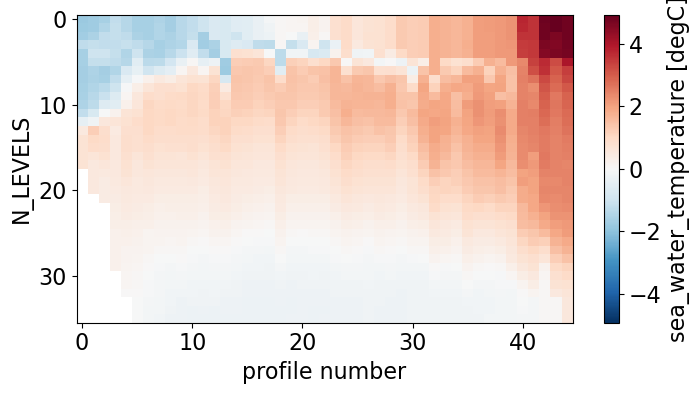

In [4]:
# Get valid ship profiles
ship_valid = ship.where(ship.N_PROF<45, drop=True)

# plt.plot(ship_valid.ctd_temperature)
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
ship_valid['ctd_temperature'].T.plot(ax=ax)

ax.margins(x=0.01)
ax.invert_yaxis()
ax.set_xlabel('profile number')

## Create Dataframe from ship file

In [4]:
# Set up variables to store 
# Warning: no pH until correction from lab to environmental conditions

dvars = ['yearday','profid', 'lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'sigma0', 'spice']  
qcvars = ['bottle_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc']

In [5]:
def make_shipDF(ship):

    dict = {
        "juld" : ship.bottle_time.values.flatten(),
        "lat" : ship.bottle_latitude.values.flatten(),
        "lon" : ship.bottle_longitude.values.flatten(),
        "pressure" : ship.pressure.values.flatten(),
        "oxygen" : ship.oxygen.values.flatten(),
        "nitrate" : ship.nitrate.values.flatten(),
        "pH_lab" : ship.ph_total_h_scale.values.flatten(),
        "Total Carbon" : ship.total_carbon.values.flatten(),
        "alkalinity" :  ship.total_alkalinity.values.flatten(),
        "salinity_qc" : ship.bottle_salinity_qc.values.flatten(),
        "oxygen_qc" : ship.oxygen_qc.values.flatten(),
        "nitrate_qc" : ship.nitrate_qc.values.flatten(),
        "pH_qc" : ship.ph_total_h_scale_qc.values.flatten(),
        "alkalinity_qc" : ship.total_alkalinity_qc.values.flatten(),
        "bottle_qc" : ship.bottle_number_qc.values.flatten()}

    bottle_data = pd.DataFrame(dict)
    
    bottle_data['SA'] = gsw.SA_from_SP(ship['bottle_salinity'].values.flatten(), bottle_data['pressure'].values, 
                                        bottle_data['lon'].values, bottle_data['lat'].values)
    bottle_data['CT'] = gsw.CT_from_t(bottle_data['SA'].values, ship['ctd_temperature'].values.flatten(), 
                                        bottle_data['pressure'].values)
    bottle_data['yearday'] = sg.datetime2ytd(bottle_data['juld'])
    bottle_data['sigma0'] = gsw.sigma0(bottle_data.SA.values, bottle_data.CT.values)
    bottle_data['spice'] = gsw.spiciness0(bottle_data["SA"].values, bottle_data["CT"].values)   
    
    # Add profile ID so you can run column analyses
    profids = []; indices = ship.to_dataframe().index
    for i in range(len(indices)):
        profids.append(indices[i][0])
    bottle_data['profid'] = profids

    bottle_data = bottle_data[dvars + qcvars + ['alkalinity', 'pH_lab']]

    return bottle_data


In [6]:
# Make dataframe with valid stations
ship_DF = make_shipDF(ship.where(ship.N_PROF<45, drop=True))
ship_DF.tail()
# can restrict to upper ~1000m by doing N_LEVELS<45

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,bottle_qc,salinity_qc,oxygen_qc,nitrate_qc,alkalinity,pH_lab
1615,121.897222,44,-49.9888,29.9851,3142.9,0.527058,34.866613,207.4,32.48,27.837403,-0.173403,2.0,2.0,2.0,2.0,2359.56,7.5907
1616,121.893056,44,-49.9884,29.9859,3400.4,0.384997,34.862080,210.3,32.64,27.842242,-0.186137,2.0,2.0,2.0,2.0,2359.60,7.5912
1617,121.889583,44,-49.9880,29.9867,3655.8,0.293074,34.863507,216.0,32.36,27.848723,-0.191183,2.0,2.0,2.0,2.0,2360.01,7.5999
1618,121.888889,44,-49.9879,29.9869,3666.5,0.284916,34.864118,216.4,32.40,27.849681,-0.191287,2.0,2.0,2.0,2.0,2359.48,7.6004
1619,121.887500,44,-49.9879,29.9871,3676.0,0.283198,34.864326,216.3,32.45,27.849947,-0.191254,2.0,2.0,2.0,2.0,2356.95,7.6007


## Add calculated variables (buoyancy)

In [7]:
ship_DF = dfproc.add_Pchip_buoyancy(ship_DF)
ship_DF.describe()

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,bottle_qc,salinity_qc,oxygen_qc,nitrate_qc,alkalinity,pH_lab,buoyancy
count,1620.000000,1620.000000,1564.000000,1564.000000,1564.000000,1544.000000,1544.000000,1545.000000,1551.000000,1544.000000,1544.000000,1564.000000,1544.000000,1546.000000,1551.000000,951.000000,984.000000,1.550000e+03
mean,-763.130423,22.000000,-60.375606,30.147405,1534.865857,0.565821,34.713597,231.284595,31.434004,27.704594,-0.268770,2.013427,2.036917,2.007115,2.003869,2339.999327,7.598300,4.940254e-06
std,4625.844964,12.991183,5.922394,0.383032,1549.197831,1.104978,0.266063,46.445621,2.520506,0.238926,0.186230,0.157390,0.205081,0.110667,0.062096,22.428792,0.037400,1.271231e-05
min,-25202.000000,0.000000,-68.354000,29.909100,3.900000,-1.807989,33.918678,169.700000,21.100000,26.716288,-0.843476,2.000000,2.000000,2.000000,2.000000,2273.950000,7.525100,-1.951301e-06
25%,107.477083,11.000000,-65.999900,29.999400,277.450000,-0.258553,34.725555,201.500000,31.475000,27.683709,-0.273856,2.000000,2.000000,2.000000,2.000000,2332.495000,7.581700,3.427775e-07
50%,110.513542,22.000000,-60.499900,30.000900,984.950000,0.494369,34.836176,214.800000,32.360000,27.820710,-0.215257,2.000000,2.000000,2.000000,2.000000,2351.230000,7.589950,6.674224e-07
75%,114.476042,33.000000,-55.001400,30.003000,2378.450000,1.254271,34.863064,241.200000,32.720000,27.847866,-0.154628,2.000000,2.000000,2.000000,2.000000,2354.875000,7.601125,2.870568e-06
max,121.959028,44.000000,-49.987900,31.535000,5955.900000,4.937691,34.946368,349.900000,35.200000,27.879300,0.008679,4.000000,4.000000,5.000000,3.000000,2365.410000,7.730700,1.130347e-04


In [8]:
size = 22
params = {'legend.fontsize': size, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura'}
plt.rcParams.update(params)

In [54]:
varmin = -1.951301e-06
varmax = 1.130347e-04

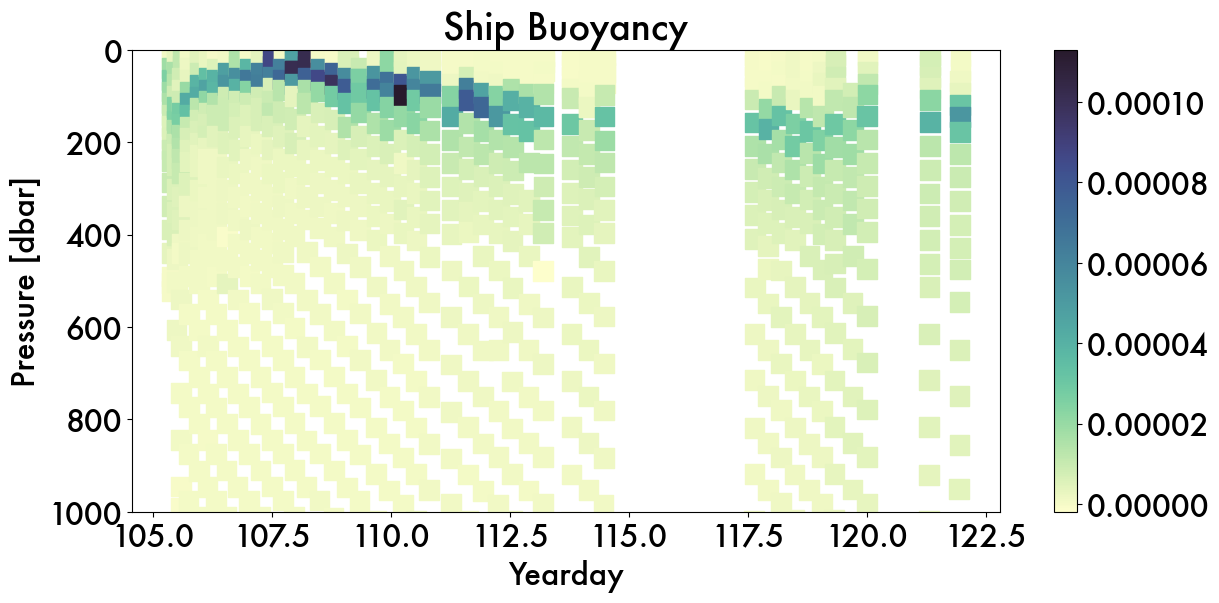

In [55]:
# Explore single  variable plot
dat = ship_DF
fig = plt.figure(figsize=(14,6))
plt.scatter(dat.yearday, dat.pressure, c=dat.buoyancy, cmap=cmo.deep, s=200, marker='s', vmin=varmin, vmax=varmax)
ax=plt.gca()
ax.invert_yaxis()

ax.set_title('Ship Buoyancy')
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_ylim([1000,0])
plt.colorbar()

## (Outdated Sep 2023) Ship Bottle pH Corrections 

- Not using 
- Make correction for ship bottle measurements of pH, which are made at a pressure of 0 and temperature of 25 (lab conditions)
- Use pyCO2sys to convert to in-situ conditions 

In [64]:
!pip install PYCO2SYS
import PyCO2SYS as pyco2

  Using cached PyCO2SYS-1.8.2-py3-none-any.whl (107 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 4.8 MB/s eta 0:00:00a 0:00:01


In [85]:
ship_DF

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,bottle_qc,salinity_qc,oxygen_qc,nitrate_qc,alkalinity,pH_lab,buoyancy
0,105.392361,0,-68.3420,31.5344,5.5,-1.807989,34.068439,348.4,27.73,27.296626,-0.841759,2.0,2.0,2.0,2.0,2297.16,7.6447,6.701985e-07
1,105.392361,0,-68.3420,31.5345,20.3,-1.803535,34.065752,348.5,27.71,27.294338,-0.843476,2.0,2.0,2.0,2.0,2296.44,7.6454,6.701985e-07
2,105.391667,0,-68.3420,31.5345,40.2,-1.720811,34.084028,345.4,27.79,27.306910,-0.828367,2.0,2.0,2.0,2.0,NaN,NaN,1.842336e-05
3,105.391667,0,-68.3420,31.5345,65.0,-1.266080,34.201334,335.6,28.57,27.387691,-0.731526,2.0,2.0,2.0,2.0,2305.27,7.6333,2.548800e-05
4,105.390972,0,-68.3420,31.5345,90.6,-1.646604,34.248555,321.8,29.54,27.437770,-0.712664,2.0,2.0,2.0,2.0,NaN,NaN,1.884913e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,121.897222,44,-49.9888,29.9851,3142.9,0.527058,34.866613,207.4,32.48,27.837403,-0.173403,2.0,2.0,2.0,2.0,2359.56,7.5907,7.794579e-07
1616,121.893056,44,-49.9884,29.9859,3400.4,0.384997,34.862080,210.3,32.64,27.842242,-0.186137,2.0,2.0,2.0,2.0,2359.60,7.5912,6.216270e-07
1617,121.889583,44,-49.9880,29.9867,3655.8,0.293074,34.863507,216.0,32.36,27.848723,-0.191183,2.0,2.0,2.0,2.0,2360.01,7.5999,1.607974e-06
1618,121.888889,44,-49.9879,29.9869,3666.5,0.284916,34.864118,216.4,32.40,27.849681,-0.191287,2.0,2.0,2.0,2.0,2359.48,7.6004,1.142661e-06


In [86]:
# Conversion runtime ~60 sec
# Measured pH are at lab Temp, Presure
# Set temp_out and pres_out to the ship's temp and pressure

pH_situ = []
for i in range(len(ship_DF)):
    # lab conditions
    pressure = 0            
    temperature = 25

    # convert to ship in-situ conditions
    try:
        result = pyco2.sys(par1 = ship_DF["alkalinity"][i],
                           par1_type = 1,
                           par2 = ship_DF["pH_lab"][i],
                           par2_type = 3,
                           opt_pH_scale = 1,
                           salinity = ship_DF["SA"][i],
                           temperature = temperature,
                           temperature_out = ship_DF["CT"][i],
                           pressure = pressure,
                           pressure_out = ship_DF["pressure"][i]
                          )
        pH_out = result["pH_out"]
    except SyntaxError: pH_out = np.nan
    pH_situ.append(pH_out)
ship_DF['pH']= pH_situ

In [88]:
ship_DF

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,bottle_qc,salinity_qc,oxygen_qc,nitrate_qc,alkalinity,pH_lab,buoyancy,pH
0,105.392361,0,-68.3420,31.5344,5.5,-1.807989,34.068439,348.4,27.73,27.296626,-0.841759,2.0,2.0,2.0,2.0,2297.16,7.6447,6.701985e-07,8.076290
1,105.392361,0,-68.3420,31.5345,20.3,-1.803535,34.065752,348.5,27.71,27.294338,-0.843476,2.0,2.0,2.0,2.0,2296.44,7.6454,6.701985e-07,8.076342
2,105.391667,0,-68.3420,31.5345,40.2,-1.720811,34.084028,345.4,27.79,27.306910,-0.828367,2.0,2.0,2.0,2.0,NaN,NaN,1.842336e-05,NaN
3,105.391667,0,-68.3420,31.5345,65.0,-1.266080,34.201334,335.6,28.57,27.387691,-0.731526,2.0,2.0,2.0,2.0,2305.27,7.6333,2.548800e-05,8.051074
4,105.390972,0,-68.3420,31.5345,90.6,-1.646604,34.248555,321.8,29.54,27.437770,-0.712664,2.0,2.0,2.0,2.0,NaN,NaN,1.884913e-05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,121.897222,44,-49.9888,29.9851,3142.9,0.527058,34.866613,207.4,32.48,27.837403,-0.173403,2.0,2.0,2.0,2.0,2359.56,7.5907,7.794579e-07,7.844103
1616,121.893056,44,-49.9884,29.9859,3400.4,0.384997,34.862080,210.3,32.64,27.842242,-0.186137,2.0,2.0,2.0,2.0,2359.60,7.5912,6.216270e-07,7.836510
1617,121.889583,44,-49.9880,29.9867,3655.8,0.293074,34.863507,216.0,32.36,27.848723,-0.191183,2.0,2.0,2.0,2.0,2360.01,7.5999,1.607974e-06,7.837322
1618,121.888889,44,-49.9879,29.9869,3666.5,0.284916,34.864118,216.4,32.40,27.849681,-0.191287,2.0,2.0,2.0,2.0,2359.48,7.6004,1.142661e-06,7.837576


In [43]:
ship_DF.keys()

Index(['Julian Day', 'Latitude', 'Longitude', 'Pressure', 'Oxygen', 'Nitrate',
       'pH_lab', 'Alkalinity', 'Salinity_QC', 'Oxygen_QC', 'Nitrate_QC',
       'pH_QC', 'Alkalinity_QC', 'Bottle_QC', 'SA', 'CT', 'Yearday', 'pH'],
      dtype='object')

In [89]:
dvars = ['yearday','profid', 'lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'sigma0', 'spice', 'buoyancy']
qcvars = ['bottle_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc']
ship_DF = ship_DF[dvars + qcvars]

## QC Corrections

In [9]:
# Flag meanings for bottle number
print('flags for bottle number')
for i, val in enumerate(ship.bottle_number_qc.attrs['flag_meanings'].split(' ')):
    print (str(i) + ': ' + val)

print(''); print('bottle flags include:' + str(ship_DF.bottle_qc.unique()))

flags for bottle number
0: no_flag_assigned
1: bottle_information_unavailable
2: no_problems_noted
3: leaking
4: did_not_trip_correctly
5: not_reported
6: significant_discrepancy_in_measured_values_between_gerard_and_niskin_bottles
7: unknown_problem
8: pair_did_not_trip_correctly_note_that_the_niskin_bottle_can_trip_at_an_unplanned_depth_while_the_gerard_trips_correctly_and_vice_versa
9: samples_not_drawn_from_this_bottle

bottle flags include:[ 2. nan  4.  3.]


In [10]:
# Flag meanings for variables
print('flags for other variables')
for i, val in enumerate(ship.bottle_salinity_qc.attrs['flag_meanings'].split(' ')):
    print (str(i) + ': ' + val)
print('')

for v in ['salinity_qc', 'oxygen_qc', 'nitrate_qc', 'bottle_qc']:
    print('flags for ' + v + ': ' + str(ship_DF[v].unique()))

flags for other variables
0: no_flag_assigned
1: sample_for_this_measurement_was_drawn_from_water_bottle_but_analysis_not_received
2: acceptable_measurement
3: questionable_measurement
4: bad_measurement
5: not_reported
6: mean_of_replicate_measurements
7: manual_chromatographic_peak_measurement
8: irregular_digital_chromatographic_peak_integration
9: sample_not_drawn_for_this_measurement_from_this_bottle

flags for salinity_qc: [ 2. nan  3.  4.]
flags for oxygen_qc: [ 2. nan  3.  5.  4.]
flags for nitrate_qc: [ 2. nan  3.]
flags for bottle_qc: [ 2. nan  4.  3.]


In [11]:
def ship_QCdrop(ship_DF, varlist=['salinity_qc', 'oxygen_qc', 'nitrate_qc', 'bottle_qc']):
    # pd.unique(ship.bottle_number_qc.values.flatten())

    nobs = len(ship_DF)
    print('original # obs: ' + str(nobs))

    for var in varlist:
        ship_DF = ship_DF[ship_DF[var] == 2]
        print('# obs: ' + str(len(ship_DF)) + ' after ' + var + ', dropped: ' + str(nobs - len(ship_DF)))
        nobs = len(ship_DF)

    # Alkalinity should keep 6 as well, if using.
    # ship_DF = ship_DF[(ship_DF['Alkalinity_QC'] == 2 | ship_DF['Alkalinity_QC'] == 6)]

    print('new # of bottle obs: ' + str(len(ship_DF)))
    return ship_DF.drop({v for v in varlist}, axis=1)

ship_qc = ship_QCdrop(ship_DF)


original # obs: 1620
# obs: 1492 after salinity_qc, dropped: 128
# obs: 1489 after oxygen_qc, dropped: 3
# obs: 1489 after nitrate_qc, dropped: 0
# obs: 1489 after bottle_qc, dropped: 0
new # of bottle obs: 1489


In [23]:
ship_qc

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,alkalinity,pH_lab,buoyancy
0,105.392361,0,-68.3420,31.5344,5.5,-1.807989,34.068439,348.4,27.73,27.296626,-0.841759,2297.16,7.6447,6.701985e-07
1,105.392361,0,-68.3420,31.5345,20.3,-1.803535,34.065752,348.5,27.71,27.294338,-0.843476,2296.44,7.6454,6.701985e-07
2,105.391667,0,-68.3420,31.5345,40.2,-1.720811,34.084028,345.4,27.79,27.306910,-0.828367,NaN,NaN,1.842336e-05
3,105.391667,0,-68.3420,31.5345,65.0,-1.266080,34.201334,335.6,28.57,27.387691,-0.731526,2305.27,7.6333,2.548800e-05
4,105.390972,0,-68.3420,31.5345,90.6,-1.646604,34.248555,321.8,29.54,27.437770,-0.712664,NaN,NaN,1.884913e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,121.897222,44,-49.9888,29.9851,3142.9,0.527058,34.866613,207.4,32.48,27.837403,-0.173403,2359.56,7.5907,7.794579e-07
1616,121.893056,44,-49.9884,29.9859,3400.4,0.384997,34.862080,210.3,32.64,27.842242,-0.186137,2359.60,7.5912,6.216270e-07
1617,121.889583,44,-49.9880,29.9867,3655.8,0.293074,34.863507,216.0,32.36,27.848723,-0.191183,2360.01,7.5999,1.607974e-06
1618,121.888889,44,-49.9879,29.9869,3666.5,0.284916,34.864118,216.4,32.40,27.849681,-0.191287,2359.48,7.6004,1.142661e-06


In [12]:
ship_qc[ship_qc.pressure<1001]

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,alkalinity,pH_lab,buoyancy
0,105.392361,0,-68.3420,31.5344,5.5,-1.807989,34.068439,348.4,27.73,27.296626,-0.841759,2297.16,7.6447,6.701985e-07
1,105.392361,0,-68.3420,31.5345,20.3,-1.803535,34.065752,348.5,27.71,27.294338,-0.843476,2296.44,7.6454,6.701985e-07
2,105.391667,0,-68.3420,31.5345,40.2,-1.720811,34.084028,345.4,27.79,27.306910,-0.828367,NaN,NaN,1.842336e-05
3,105.391667,0,-68.3420,31.5345,65.0,-1.266080,34.201334,335.6,28.57,27.387691,-0.731526,2305.27,7.6333,2.548800e-05
4,105.390972,0,-68.3420,31.5345,90.6,-1.646604,34.248555,321.8,29.54,27.437770,-0.712664,NaN,NaN,1.884913e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,121.941667,44,-49.9924,29.9761,545.5,2.629259,34.490819,199.5,33.84,27.382888,-0.263153,2308.31,7.5518,7.175607e-06
1598,121.939583,44,-49.9923,29.9766,649.3,2.520786,34.570119,186.4,34.42,27.455214,-0.217707,2318.03,7.5406,6.055327e-06
1599,121.937500,44,-49.9920,29.9771,750.2,2.485632,34.636733,177.9,34.47,27.511159,-0.174170,2325.48,7.5394,5.170273e-06
1600,121.935417,44,-49.9918,29.9777,855.9,2.427224,34.698483,172.7,34.36,27.565203,-0.136247,2331.40,7.5408,4.727127e-06


In [13]:
# Add calculated variables for oxygen.
ship_qc['o2sat'] = gsw.O2sol(ship_qc['SA'], ship_qc['CT'], ship_qc['pressure'], ship_qc['lon'], ship_qc['lat'])
ship_qc['AOU'] = gsw.O2sol(ship_qc['SA'], ship_qc['CT'], ship_qc['pressure'], ship_qc['lon'], ship_qc['lat']) - ship_qc['oxygen']

# ship_qc['oxygen_psat'] = ship_qc['oxygen']/ship_qc['o2sat']


In [27]:
ship_qc

,yearday,profid,lat,lon,pressure,CT,SA,oxygen,nitrate,sigma0,spice,alkalinity,pH_lab,buoyancy,o2sat,AOU
0,105.392361,0,-68.3420,31.5344,5.5,-1.807989,34.068439,348.4,27.73,27.296626,-0.841759,2297.16,7.6447,6.701985e-07,368.180862,19.780862
1,105.392361,0,-68.3420,31.5345,20.3,-1.803535,34.065752,348.5,27.71,27.294338,-0.843476,2296.44,7.6454,6.701985e-07,368.144501,19.644501
2,105.391667,0,-68.3420,31.5345,40.2,-1.720811,34.084028,345.4,27.79,27.306910,-0.828367,NaN,NaN,1.842336e-05,367.271230,21.871230
3,105.391667,0,-68.3420,31.5345,65.0,-1.266080,34.201334,335.6,28.57,27.387691,-0.731526,2305.27,7.6333,2.548800e-05,362.479649,26.879649
4,105.390972,0,-68.3420,31.5345,90.6,-1.646604,34.248555,321.8,29.54,27.437770,-0.712664,NaN,NaN,1.884913e-05,366.061545,44.261545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,121.897222,44,-49.9888,29.9851,3142.9,0.527058,34.866613,207.4,32.48,27.837403,-0.173403,2359.56,7.5907,7.794579e-07,344.013091,136.613091
1616,121.893056,44,-49.9884,29.9859,3400.4,0.384997,34.862080,210.3,32.64,27.842242,-0.186137,2359.60,7.5912,6.216270e-07,345.290330,134.990330
1617,121.889583,44,-49.9880,29.9867,3655.8,0.293074,34.863507,216.0,32.36,27.848723,-0.191183,2360.01,7.5999,1.607974e-06,346.109417,130.109417
1618,121.888889,44,-49.9879,29.9869,3666.5,0.284916,34.864118,216.4,32.40,27.849681,-0.191287,2359.48,7.6004,1.142661e-06,346.180923,129.780923


In [28]:
file_path ='/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/go-ship/'
filename = '325020190403_ship_qc_sep2023.csv'
ship_qc.to_csv(file_path + filename)